In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
np.set_printoptions(precision=4, threshold=500)
pd.options.display.max_rows = 100
%matplotlib inline
import sys
sys.path.insert(0,'/usr/local/Cellar/opencv3/3.2.0/lib/python2.7/site-packages')
import cv2

In [2]:
class SquareLoss:
    def forward(self, y, t):
        self.loss = y - t
        return np.sum(self.loss * self.loss) /  self.loss.shape[1] / 2
    def backward(self):
        return self.loss

In [3]:
class FC:
    def __init__(self, in_num, out_num, lr = 0.1):
        self._in_num = in_num
        self._out_num = out_num
        self.w = np.random.randn(in_num, out_num)
        self.b = np.zeros((out_num, 1))
        self.lr = lr
    def _sigmoid(self, in_data):
        return 1 / (1 + np.exp(-in_data))
    def forward(self, in_data):
        self.topVal = self._sigmoid(np.dot(self.w.T, in_data) + self.b)
        self.bottomVal = in_data
        return self.topVal
    def backward(self, loss):
        residual_z = loss * self.topVal * (1 - self.topVal)
        grad_w = np.dot(self.bottomVal, residual_z.T)
        grad_b = np.sum(residual_z)
        self.w -= self.lr * grad_w
        self.b -= self.lr * grad_b
        residual_x = np.dot(self.w, residual_z)
        return residual_x

In [4]:
class Net:
    def __init__(self, input_num=2, hidden_num=4, out_num=1, lr=0.1):
        self.fc1 = FC(input_num, hidden_num, lr)
        self.fc2 = FC(hidden_num, out_num, lr)
        self.loss = SquareLoss()
    def train(self, X, Y): # X are arranged by col
        for i in range(10000):
            # forward step
            layer1out = self.fc1.forward(X)
            layer2out = self.fc2.forward(layer1out)
            loss = self.loss.forward(layer2out, Y)
            # backward step
            layer2loss = self.loss.backward()
            layer1loss = self.fc2.backward(layer2loss)
            saliency = self.fc1.backward(layer1loss)
        layer1out = self.fc1.forward(X)
        layer2out = self.fc2.forward(layer1out)
        print 'X={0}'.format(X)
        print 't={0}'.format(Y)
        print 'Y={0}'.format(layer2out)

In [5]:
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]]).T
Y = np.array([[0],[0],[0],[1]]).T

net = Net(2,4,1,0.1)
net.train(X,Y)
net.loss.loss

X=[[0 0 1 1]
 [0 1 0 1]]
t=[[0 0 0 1]]
Y=[[ 0.0061  0.0295  0.0297  0.9656]]


array([[ 0.0061,  0.0295,  0.0297, -0.0344]])

In [6]:
import numpy as np
import matplotlib.pyplot as plt
def conv2(X, k):
    x_row, x_col = X.shape
    k_row, k_col = k.shape
    ret_row, ret_col = x_row - k_row + 1, x_col - k_col + 1
    ret = np.empty((ret_row, ret_col))
    for y in range(ret_row):
        for x in range(ret_col):
            sub = X[y : y + k_row, x : x + k_col]
            ret[y,x] = np.sum(sub * k)
    return ret

class ConvLayer:
    def __init__(self, in_channel, out_channel, kernel_size):
        self.w = np.random.randn(in_channel, out_channel, kernel_size, kernel_size)
        self.b = np.zeros((out_channel))
    def _relu(self, x):
        x[x < 0] = 0
        return x
    def forward(self, in_data):
        # assume the first index is channel index
        in_channel, in_row, in_col = in_data.shape
        out_channel, kernel_row, kernel_col = self.w.shape[1], self.w.shape[2], self.w.shape[3]
        self.top_val = np.zeros((out_channel, in_row - kernel_row + 1, in_col - kernel_col + 1))
        for j in range(out_channel):
            for i in range(in_channel):
                self.top_val[j] += conv2(in_data[i], self.w[i, j])
            self.top_val[j] += self.b[j]
            self.top_val[j] = self._relu(self.top_val[j])
        return self.top_val

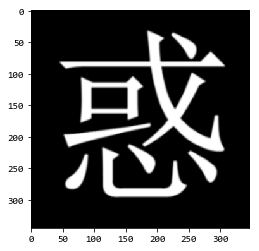

In [7]:
import cv2
mat = cv2.imread('conv1.png',0)
row,col = mat.shape
in_data = mat.reshape(1,row,col)
in_data = in_data.astype(np.float) / 255
plt.imshow(in_data[0], cmap='Greys_r')

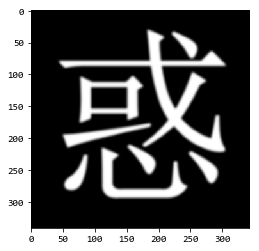

In [8]:
meanConv = ConvLayer(1,1,5)
meanConv.w[0,0] = np.ones((5,5)) / (5 * 5)
mean_out = meanConv.forward(in_data)
plt.imshow(mean_out[0], cmap='Greys_r')

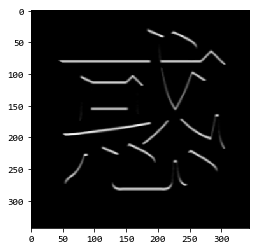

In [9]:
sobelConv = ConvLayer(1,1,3)
sobelConv.w[0,0] = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
sobel_out = sobelConv.forward(in_data)
plt.imshow(sobel_out[0], cmap='Greys_r')

[[-0.2676 -0.4412 -0.2676]
 [ 0.6065  1.      0.6065]
 [-0.2676 -0.4412 -0.2676]]


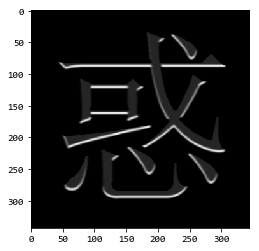

In [10]:
def gabor_fn(sigma, theta, Lambda, psi, gamma):
    sigma_x = sigma
    sigma_y = float(sigma) / gamma
    (y, x) = np.meshgrid(np.arange(-1,2), np.arange(-1,2))
    # Rotation 
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)
    gb = np.exp(-.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) * np.cos(2 * np.pi / Lambda * x_theta + psi)
    return gb
print gabor_fn(2, 0, 0.3, 0, 2)
gaborConv = ConvLayer(1,1,3)
gaborConv.w[0,0] = gabor_fn(2, 0, 0.3, 1, 2)
gabor_out = gaborConv.forward(in_data)
plt.imshow(gabor_out[0], cmap='Greys_r')

In [11]:
sobel_kernel = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
np.fft.fftshift(np.fft.fft2(sobel_kernel)).astype(np.float32)

array([[  1.5000e+00,  -6.0000e+00,  -6.6613e-16],
       [  0.0000e+00,   0.0000e+00,   0.0000e+00],
       [ -6.6613e-16,  -6.0000e+00,   1.5000e+00]], dtype=float32)

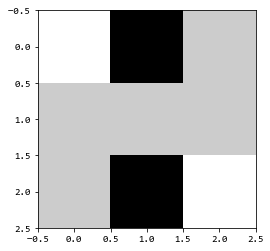

In [12]:
plt.imshow(np.fft.fftshift(np.fft.fft2(sobel_kernel)).astype(np.float32), cmap="gray")